# Projeto 3 - DNN e Transfer Learning

---------------------------------------------

### Participants:
 - Francielle Vargas - 9527629
 - Lucas Nunes Sequeira - 9009642
 - Emanuel Huber - 12110113

#### Date: 11/11/2021

---------------------------------------------

#### Descrição e Instrução

Este notebook foi feito para a disciplina SCC5809 - Redes Neurais

No notebook contém

1. A implementação da rede **MobileNetV2**
2. Utilização do modelo no dataset [**Cats and Dogs**](https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip)
3. Avaliação do modelo com **Acurácia**

Para utilizá-lo basta executar todas as células.

_link de acesso ao colab: https://colab.research.google.com/drive/1oTHXvcum_W62XFBkrXJ1Jlm725LkV7b4?usp=sharing_

In [1]:
!nvidia-smi

Mon Nov 29 14:35:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    80W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Libs

In [2]:
# # Install Libs
# !pip install -U numpy
# !pip install tqdm==4.62.0
# !pip install plotly==4.4.1
# !pip install pandas==1.1.5
# !pip install scikit-learn==0.24.2
# !pip install tensorflow==2.6.0
# !pip install lime==0.2.0.1
# !pip install Augmentor==0.2.8

In [3]:
# Math lib
import numpy as np

# Log lib
from tqdm.auto import tqdm

# Image lib
from PIL import Image, ImageOps

# Visualization Lib
import plotly.express as px
import plotly.graph_objects as go

# Copy for deepcopy
import copy

# Pandas for visualization
import pandas as pd
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import accuracy_score

# TensorFlow e tf.keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# OS
import os
import shutil
from google.colab import files
import gdown

# Seed
SEED = 42

# Set random seed
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Load/Prep Data

**Source:**
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

**Format:**

```
cats_and_dogs_filtered.zip/
└── cats_and_dogs_filtered/
    ├── train/
    │    ├── cats
    │    │    ├── 0001.png
    │    │    ├── ...
    │    │    └── 5985.png
    │    ...
    │    └── dogs
    │         ├── 0001.png
    │         ├── ...
    │         └── 5985.png
   ...
    └── validation/
         ├── cats
         │    ├── 0001.png
         │    ├── ...
         │    └── 5985.png
         ...
         └── dogs
              ├── 0001.png
              ├── ...
              └── 5985.png
```

#### Upload Data

In [4]:
# Load Cats and Dogs files
!rm -r cats_and_dogs_filtered.zip
gdown.download('https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip', 'cats_and_dogs_filtered.zip', quiet=False)

# Extract files
!rm -r cats_and_dogs_filtered
!unzip cats_and_dogs_filtered.zip

Downloading...
From: https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
To: /content/cats_and_dogs_filtered.zip
100%|██████████| 68.6M/68.6M [00:00<00:00, 153MB/s]


Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.

#### Load train/val

In [5]:
CLASS_NAMES = ['cat', 'dog']
BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)

# Load Data
train_ds = tf.keras.preprocessing.image_dataset_from_directory("cats_and_dogs_filtered/train", 
                                                               shuffle=True,
                                                               seed=SEED,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMAGE_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory("cats_and_dogs_filtered/validation", 
                                                             shuffle=False,
                                                             seed=SEED,
                                                             batch_size=BATCH_SIZE,
                                                             image_size=IMAGE_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


#### Augmentate data

In [6]:
def augmantate(ds, buffer_size = 10000):

  # Flip horizonal
  for images, labels in iter(ds):

    # Flip images
    images = tf.image.flip_left_right(images)

    # Generate new batch
    new_batch = tf.data.Dataset.from_tensor_slices((images, labels)).batch(BATCH_SIZE)

    # Add batch
    ds = ds.concatenate(new_batch)

  return ds.shuffle(buffer_size, seed=SEED).prefetch(buffer_size)

train_ds = augmantate(train_ds)

#### Visualize data

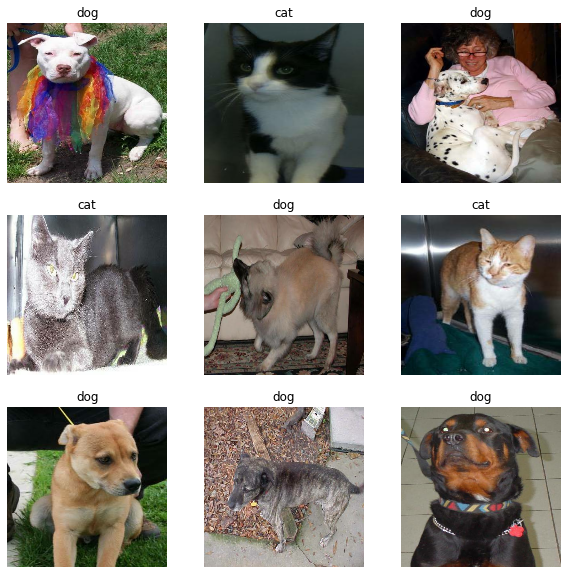

In [7]:
# Initialize Figure
plt.figure(figsize=(10, 10))
figures = 9

# Iterate over train dataset first batch
for images, labels in train_ds.take(1):
  for i in range(figures):
    # Subplot
    ax = plt.subplot(3, 3, i + 1)

    # Show data
    plt.imshow(images[i].numpy().astype(np.uint8))
    plt.title(CLASS_NAMES[int(labels[i])])
    plt.axis("off")

### Build Model

- Modelagem com o **MobileNet**

#### MobileNet

In [8]:
def build_network(input_shape, num_classes, use_imagenet_weights = True):

  # INPUT BLOCK #

  # Input layer
  inputs = keras.Input(shape=(input_shape))

  # Normalization
  x = keras.layers.Rescaling(scale = 1.0 / 255)(inputs)

  # Augmentation
  x = keras.layers.RandomRotation(0.2, seed=SEED)(x)

  # MobileNet BLOCK #
  if use_imagenet_weights:
    mobilenet_block = keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_tensor=x)
  else:
    mobilenet_block = keras.applications.MobileNetV2(weights=None, include_top=False, input_tensor=x)

  # Freezing layers (iff uses imagenet weights)
  freeze_layers = not use_imagenet_weights # False if uses imagenet weights
  for layer in mobilenet_block.layers:
      layer.trainable = freeze_layers

  # TRANSFER LEARNING BLOCK #
  x = keras.layers.GlobalAveragePooling2D()(mobilenet_block.output)
  x = keras.layers.Dropout(0.4)(x)
  x = keras.layers.Dense(128, activation="relu")(x)
  residual = x

  # Residual block
  x = keras.layers.Dropout(0.4)(x)
  x = keras.layers.Dense(128, activation="relu")(x)
  x = keras.layers.Dropout(0.4)(x)

  # Compile residual
  x = keras.layers.Add()([x, residual])
  x = keras.layers.BatchNormalization()(x)
  
  # Prediction Layer
  outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name="TransferMobileNet")

  return model

In [9]:
# Build model
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
network_finetune = build_network(input_shape=input_shape, num_classes=len(CLASS_NAMES))
network_scratch = build_network(input_shape=input_shape, num_classes=len(CLASS_NAMES), use_imagenet_weights=False)

# Compile model
learning_rate = 0.003
network_finetune.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

network_scratch.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

network_finetune.summary()
plot_model(network_finetune, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

### Train Model

- Treinamento dos modelos considerando:
  - Adam optimizer
  - loss: sparse_categorical_crossentropy
  - métrica: accuracy
  - épocas: 10

#### Methods

In [10]:
def train_model(model, train_ds, val_ds, max_epochs = 10):
  '''
  Train a given model and return its history
  '''
  # Train
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                patience=1, min_lr=0.0001)

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

  history = model.fit(train_ds, validation_data=val_ds, epochs=max_epochs, callbacks=[reduce_lr, early_stopping])

  return history

#### Training

In [11]:
MAX_EPOCHS = 10

# Buffer data
train = train_ds.prefetch(buffer_size=32)
val = val_ds.prefetch(buffer_size=32)

# Train From Scratch
history_scratch = train_model(network_scratch, train, val, MAX_EPOCHS)

Epoch 1/10
126/126 [==============================] - 40s 229ms/step - loss: 0.7779 - accuracy: 0.5502 - val_loss: 0.6943 - val_accuracy: 0.5000 - lr: 0.0030
Epoch 2/10
126/126 [==============================] - 29s 208ms/step - loss: 0.6965 - accuracy: 0.5710 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0030
Epoch 3/10
126/126 [==============================] - 29s 207ms/step - loss: 0.6803 - accuracy: 0.5910 - val_loss: 0.7163 - val_accuracy: 0.5000 - lr: 0.0030
Epoch 4/10
126/126 [==============================] - 29s 207ms/step - loss: 0.6173 - accuracy: 0.6665 - val_loss: 0.7013 - val_accuracy: 0.5000 - lr: 6.0000e-04


In [12]:
# Buffer data
train = train_ds.prefetch(buffer_size=32)
val = val_ds.prefetch(buffer_size=32)

# Finetune Imagenet Weights
history_finetune = train_model(network_finetune, train, val, MAX_EPOCHS)

Epoch 1/10
126/126 [==============================] - 27s 75ms/step - loss: 0.3082 - accuracy: 0.8780 - val_loss: 0.1109 - val_accuracy: 0.9560 - lr: 0.0030
Epoch 2/10
126/126 [==============================] - 11s 67ms/step - loss: 0.2238 - accuracy: 0.9028 - val_loss: 0.1144 - val_accuracy: 0.9610 - lr: 0.0030
Epoch 3/10
126/126 [==============================] - 11s 68ms/step - loss: 0.1892 - accuracy: 0.9220 - val_loss: 0.1068 - val_accuracy: 0.9580 - lr: 6.0000e-04
Epoch 4/10
126/126 [==============================] - 11s 66ms/step - loss: 0.1856 - accuracy: 0.9233 - val_loss: 0.0986 - val_accuracy: 0.9610 - lr: 6.0000e-04
Epoch 5/10
126/126 [==============================] - 11s 66ms/step - loss: 0.1792 - accuracy: 0.9277 - val_loss: 0.1009 - val_accuracy: 0.9600 - lr: 6.0000e-04
Epoch 6/10
126/126 [==============================] - 11s 68ms/step - loss: 0.1819 - accuracy: 0.9222 - val_loss: 0.0982 - val_accuracy: 0.9610 - lr: 1.2000e-04
Epoch 7/10
126/126 [======================

#### Training Metric/Loss

##### Prepare Metrics

In [13]:
# Prepare dataframe of training metrics

train_metrics_df = pd.DataFrame()
train_histories = {
    'Scratch': history_scratch.history,
    'Finetune': history_finetune.history,
}

for model_type, history in train_histories.items():

  tmp_df = pd.DataFrame()

  for metric, values in history.items():
    tmp_df[metric] = values
  tmp_df['model'] = [model_type]*len(tmp_df)
  tmp_df['epoch'] = np.arange(1, len(tmp_df)+1)

  # Concat dataframe
  train_metrics_df = pd.concat((train_metrics_df, tmp_df))

train_metrics_df

,loss,accuracy,val_loss,val_accuracy,lr,model,epoch
0,0.777898,0.55025,0.694291,0.500,0.00300,Scratch,1
1,0.696454,0.57100,0.693280,0.500,0.00300,Scratch,2
2,0.680295,0.59100,0.716258,0.500,0.00300,Scratch,3
3,0.617314,0.66650,0.701342,0.500,0.00060,Scratch,4
0,0.308230,0.87800,0.110901,0.956,0.00300,Finetune,1
1,0.223777,0.90275,0.114435,0.961,0.00300,Finetune,2
2,0.189171,0.92200,0.106835,0.958,0.00060,Finetune,3
3,0.185561,0.92325,0.098643,0.961,0.00060,Finetune,4
4,0.179166,0.92775,0.100910,0.960,0.00060,Finetune,5
5,0.181889,0.92225,0.098193,0.961,0.00012,Finetune,6


##### Visualizations

In [14]:
px.line(train_metrics_df, x="epoch", y="accuracy", color="model", title="Accuracy on Training")

In [15]:
px.line(train_metrics_df, x="epoch", y="loss", color="model", title="Loss on Training")

In [16]:
px.line(train_metrics_df, x="epoch", y="val_accuracy", color="model", title="Accuracy on Validation")

In [17]:
px.line(train_metrics_df, x="epoch", y="val_loss", color="model", title="Loss on Validation")

### Evaluation and Predictions

#### Model from scratch

In [18]:
metrics = network_scratch.evaluate(val_ds, verbose=2)

print('\nModel from scratch:')
print('> Loss:', metrics[0])
print('> Accuracy:', metrics[1])

32/32 - 2s - loss: 0.7013 - accuracy: 0.5000 - 2s/epoch - 56ms/step

Model from scratch:
> Loss: 0.7013420462608337
> Accuracy: 0.5


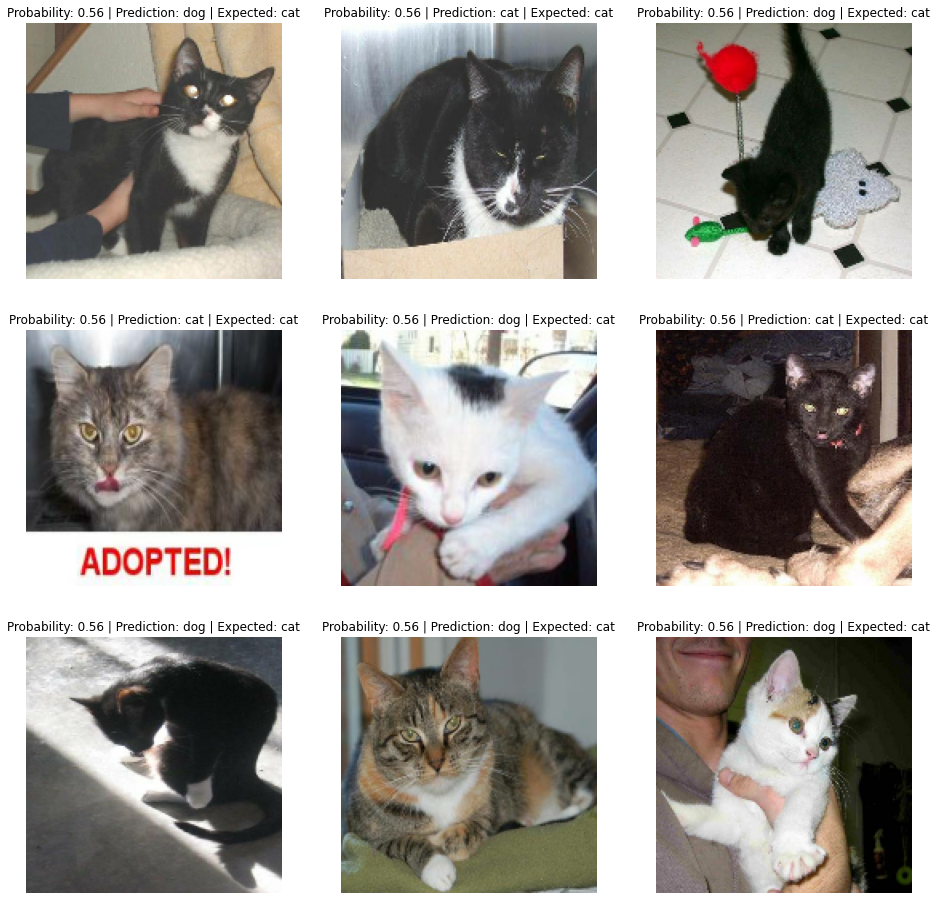

In [19]:
# Scratch

# Initialize Figure
plt.figure(figsize=(16, 16))
figures = 9

# Iterate over train dataset first batch
for images, true_labels in val_ds.take(1):

  # Make predictions
  logits = network_scratch.predict(images)
  predictions = tf.argmax(logits, axis=1).numpy()
  predicted_labels = labels.numpy()

  for i in range(figures):
    # Subplot
    ax = plt.subplot(3, 3, i + 1)

    # Show data
    plt.imshow(images[i].numpy().astype(np.uint8))
    plt.title(
        f'Probability: {str(round(logits[i][predictions[i]], 2))} | ' + 
        f'Prediction: {CLASS_NAMES[int(predicted_labels[i])]} | ' + 
        f'Expected: {CLASS_NAMES[int(true_labels[i])]}')
    plt.axis("off")

#### Model finetuned (transfer lerning)

In [20]:
metrics = network_finetune.evaluate(val_ds, verbose=2)

print('\nModel finetuned:')
print('> Loss:', metrics[0])
print('> Accuracy:', metrics[1])

32/32 - 2s - loss: 0.0955 - accuracy: 0.9660 - 2s/epoch - 61ms/step

Model finetuned:
> Loss: 0.09546519815921783
> Accuracy: 0.9660000205039978


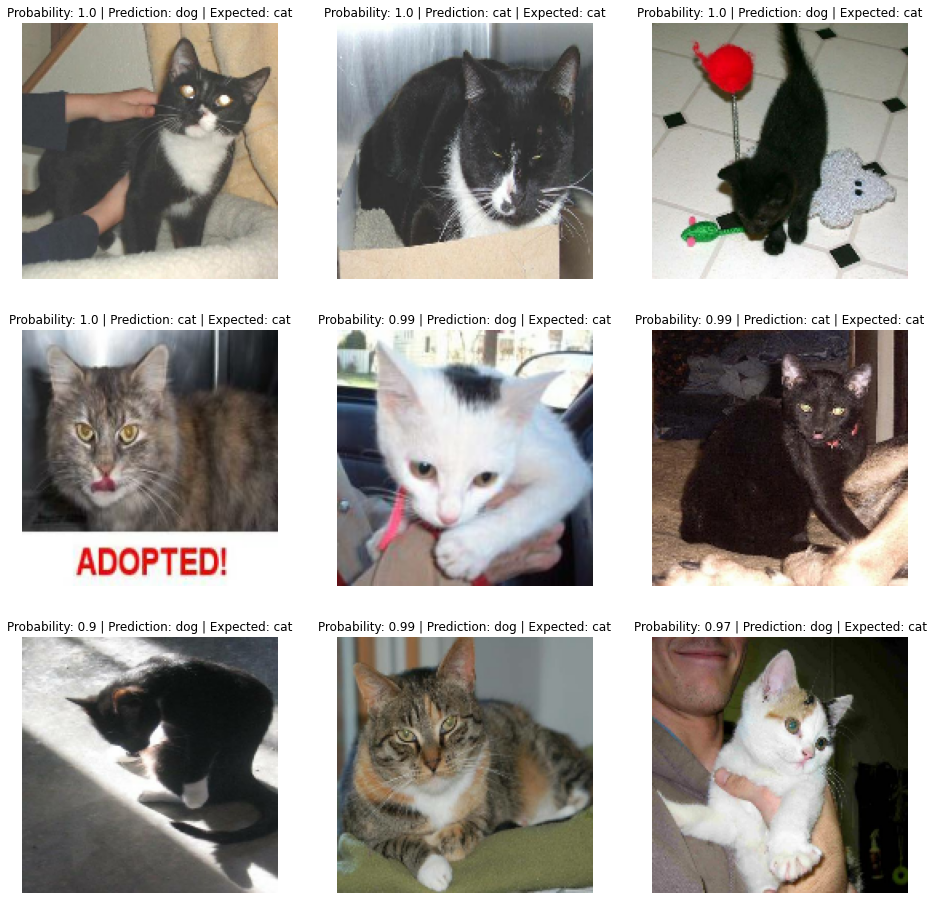

In [21]:
# Finetuned

# Initialize Figure
plt.figure(figsize=(16, 16))
figures = 9

# Iterate over train dataset first batch
for images, true_labels in val_ds.take(1):

  # Make predictions
  logits = network_finetune.predict(images)
  predictions = tf.argmax(logits, axis=1).numpy()
  predicted_labels = labels.numpy()

  for i in range(figures):
    # Subplot
    ax = plt.subplot(3, 3, i + 1)

    # Show data
    plt.imshow(images[i].numpy().astype(np.uint8))
    plt.title(
        f'Probability: {str(round(logits[i][predictions[i]], 2))} | ' + 
        f'Prediction: {CLASS_NAMES[int(predicted_labels[i])]} | ' + 
        f'Expected: {CLASS_NAMES[int(true_labels[i])]}')
    plt.axis("off")

### Predictions

#### Methods

In [22]:
from google.colab import files

def load_input():
  '''
  Load model weights and input images for prediction
  '''

  # Manage directory
  try:
    shutil.rmtree('input_files')
  except:
    pass

  try:
    os.makedirs('input_files')
  except:
    pass

  # Load file
  print("Por favor, faça o upload de imagens:")
  uploaded = files.upload()

  # Get image names
  image_names = list(uploaded.keys())

  # Move, assert and preprocess each image
  images = []
  for image_name in image_names:

    # Move to input folder
    os.replace(image_name, f'input_files/{image_name}')

    # Load Image
    image = Image.open(f'input_files/{image_name}')

    # Apply transformations
    image = np.array(image.resize((IMAGE_SIZE[0], IMAGE_SIZE[1])))

    # Append image
    images.append(image)

  return np.array(images)

def predict(images, model):
  '''
  Make prediction and return most probable classes
  '''
  # Predictions
  logits = model.predict(images)

  # Apply argmax
  predictions = np.argmax(logits, axis=1)

  # Get class name
  class_names = [CLASS_NAMES[prediction] for prediction in predictions]

  return class_names

def show_predictions(images, predictions, model_name):

  # Initialize Figure
  plt.figure(figsize=(10, 10))

  # Iterate over each result and image
  for i, (image, label) in enumerate(zip(images, predictions)):

      # Subplot
      ax = plt.subplot(3, 3, i + 1)

      # Show data
      plt.imshow(image)
      plt.title(label + ' - ' + model_name)
      plt.axis("off")

#### External Input

Por favor, faça o upload de imagens:


Saving cat.jpg to cat.jpg
Saving dog.jpg to dog.jpg


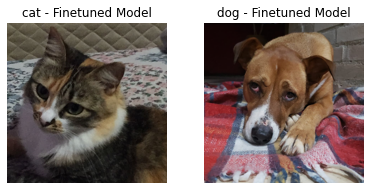

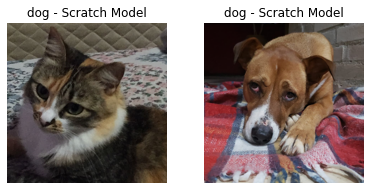

In [23]:
# Load Model and Images
images = load_input()

# Prediction
predictions_finetuned = predict(images, network_finetune)
predictions_scratch = predict(images, network_scratch)

# Visualize predictions
show_predictions(images, predictions_finetuned, 'Finetuned Model')
show_predictions(images, predictions_scratch, 'Scratch Model')